In [1]:
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

import sklearn
import itertools
from sklearn.metrics import confusion_matrix

In [2]:
def proc_image_dir(Images_Path):
    
    image_classes = sorted([dirname for dirname in os.listdir(Images_Path)
                      if os.path.isdir(os.path.join(Images_Path, dirname)) and not dirname.startswith(".") and not dirname.startswith("mblur")])
    image_classes.append('mblur')
    
    print(image_classes)
    
    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 256
    HEIGHT = 256
  
    print("Adding Images: ",end="")
    i = 0
    for image_class in image_classes:
        print("Processing ", image_class)
        items = glob(os.path.join(Images_Path, image_class,"*"))
        for item in items:
            if item.lower().endswith(".jpg") or item.lower().endswith(".bmp") or item.lower().endswith(".ppm"):
                # Read and resize image
                full_size_image = cv2.imread(item)
                
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                out = [0] * len(image_classes)
                out[i] = 1
                y.append(out)
        i+=1

    print("")
    return x,y,image_classes


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         figure_size=(5,5)):
    from matplotlib.transforms import offset_copy
    plt.figure(figsize = figure_size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    y_tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(y_tick_marks,labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("./fig/cm-"+title+".png")
    plt.show()
    
def horizontal_motion_blur(img, blur_factor):
    import cv2 
    import numpy as np 

    kernel_size = blur_factor
    kernel_h = np.zeros((kernel_size, kernel_size))
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size) 
    kernel_h /= kernel_size 

    # Apply the horizontal kernel. 
    horizontal_mb = cv2.filter2D(img, -1, kernel_h) 
    
    return horizontal_mb

In [3]:
# ./input/
PATH = os.path.abspath(os.path.join('.', 'databaserelease2'))

# ./input/sample/images/
SOURCE_IMAGES = PATH#os.path.join(PATH, "sample", "images")

x2,y2,image_classes = proc_image_dir(SOURCE_IMAGES)

#for el in y2:
#    el = el.append(0)

#image_classes.append('mblur')


['bad_lighting', 'gblur', 'jp2k', 'refimgs', 'wn', 'mblur']
Adding Images: Processing  bad_lighting
Processing  gblur
Processing  jp2k
Processing  refimgs
Processing  wn
Processing  mblur



In [4]:

for i in range(0,len(x2)):
    if(y2[i][2] > 0):
        # Specify the kernel size. 
        # The greater the size, the more the motion. 
        
        random.seed(221234)
        kernel_size_h = random.randrange(30, 60, 5)


        # Apply the horizontal kernel. 
        horizonal_mb = horizontal_motion_blur(x2[i],kernel_size_h)
        
        x2.append(horizonal_mb)
        y2.append([0,0,0,0,0,1])

print(image_classes)
        
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x2,y2, test_size=0.2, random_state=1, stratify=y2)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

['bad_lighting', 'gblur', 'jp2k', 'refimgs', 'wn', 'mblur']
(788, 256, 256, 3)
(99, 256, 256, 3)
(98, 256, 256, 3)


In [5]:
K.image_data_format()

img_width, img_height = 256, 256
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 100
batch_size = 16

In [6]:
model = models.Sequential()

In [7]:
model.add(layers.Conv2D(32, (5, 5), input_shape=(img_width, img_height, 3)))

In [8]:
model.add(layers.BatchNormalization())
model.add(layers.Activation("softmax"))

model.add(layers.MaxPooling2D((2, 2)))

In [9]:
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("softmax"))

model.add(layers.MaxPooling2D((2, 2)))

In [10]:
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("softmax"))

model.add(layers.MaxPooling2D((2, 2)))

In [11]:
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.2))

In [12]:
model.add(layers.Dense(len(image_classes)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("sigmoid"))

In [13]:
model.compile(
	loss='binary_crossentropy',
	optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
	metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 64)      0

In [14]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect')
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), epochs=50)

Train on 788 samples, validate on 99 samples
Epoch 1/50
352/788 [============>.................] - ETA: 16s - loss: 0.7384 - acc: 0.5297

KeyboardInterrupt: 

In [133]:
model.save_weights('8020weights.h5')

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("./fig/trvlAcc.png")
plt.show()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("./fig/trvlLoss.png")
plt.show()

NameError: name 'history' is not defined

In [17]:
model.load_weights('8020weights.h5')

In [18]:
    

a=np.array(X_test).astype(float)
b=np.array(y_test)
Y_pred = model.predict(a)

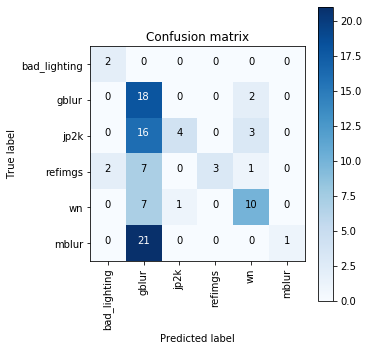

In [19]:

    
Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes))

In [20]:
model.compile(
	loss='binary_crossentropy',
	optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
	metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 64)      0

In [139]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.90, 1.1],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect')
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)
cb = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=20,verbose=0,mode='auto',baseline=None,restore_best_weights=True)

history2 = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), epochs=200, callbacks=[cb])

Train on 788 samples, validate on 99 samples
Epoch 1/200
788/788 [==============================] - 20s 25ms/sample - loss: 0.2210 - acc: 0.9655 - val_loss: 0.3646 - val_acc: 0.8923
Epoch 2/200
788/788 [==============================] - 17s 22ms/sample - loss: 0.2218 - acc: 0.9655 - val_loss: 0.2866 - val_acc: 0.9141
Epoch 3/200
788/788 [==============================] - 17s 22ms/sample - loss: 0.2238 - acc: 0.9636 - val_loss: 0.2722 - val_acc: 0.9327
Epoch 4/200
788/788 [==============================] - 17s 22ms/sample - loss: 0.2187 - acc: 0.9672 - val_loss: 0.2741 - val_acc: 0.9343
Epoch 5/200
788/788 [==============================] - 17s 22ms/sample - loss: 0.2163 - acc: 0.9683 - val_loss: 0.2704 - val_acc: 0.9377
Epoch 6/200
788/788 [==============================] - 17s 22ms/sample - loss: 0.2191 - acc: 0.9664 - val_loss: 0.2643 - val_acc: 0.9360
Epoch 7/200
788/788 [==============================] - 17s 22ms/sample - loss: 0.2198 - acc: 0.9657 - val_loss: 0.2626 - val_acc: 0.9

In [140]:
model.save_weights('8020weights2.h5')

In [21]:
model.load_weights('8020weights2.h5')

In [13]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("./fig/trvlAcc2.png")
plt.show()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("./fig/trvlLoss2.png")
plt.show()
    

NameError: name 'history2' is not defined

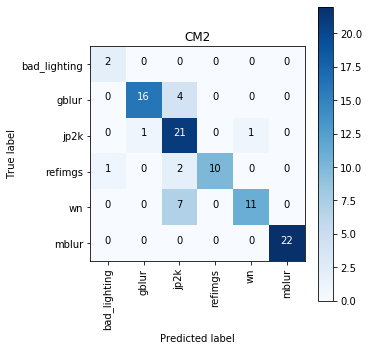

0.8367346938775511

In [22]:
a=np.array(X_test).astype(float)
b=np.array(y_test)
Y_pred = model.predict(a)


Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes), title='CM2')
sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))

In [23]:
model.load_weights('8020weights2.h5')
a=np.array(X_test).astype(float)
b=np.array(y_test)
Y_pred = model.predict(a)


Y_pred_classes = np.argmax(Y_pred,axis=1)


sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))

0.8367346938775511

In [44]:
class_totals = [sum(i) for i in confusion_mtx]
class_totals

tp = [confusion_mtx[i][i] for i in range(6)]
tp

sensetivity = [tp[i]/class_totals[i] for i in range(6)]
sensetivity

[1.0, 0.8, 0.9130434782608695, 0.7692307692307693, 0.6111111111111112, 1.0]

In [45]:
fp = [[sum(x) for x in zip(*confusion_mtx)][i] - tp[i] for i in range(6)]
fp

[1, 1, 13, 0, 1, 0]

In [47]:
sumall = sum(map(sum, confusion_mtx))
print(sumall)
tn = [sumall - [sum(x) for x in zip(*confusion_mtx)][i] for i in range(6)]
tn
specificity = [tn[i]/(tn[i]+fp[i]) for i in range(6)]
specificity

98


[0.9895833333333334,
 0.9878048780487805,
 0.8311688311688312,
 1.0,
 0.9885057471264368,
 1.0]

In [14]:
# ./input/
PATH = os.path.abspath(os.path.join('.', 'trafficImages'))

# ./input/sample/images/
SOURCE_IMAGES = PATH#os.path.join(PATH, "sample", "images")

X_traffic,Y_traffic,image_classes2 = proc_image_dir(SOURCE_IMAGES)

print(np.array(X_traffic).shape)
print(np.array(Y_traffic).shape)
print(Y_traffic)

['bad_lighting', 'gblur', 'refimgs', 'mblur']
Adding Images: Processing  bad_lighting
Processing  gblur
Processing  refimgs
Processing  mblur

(172, 256, 256, 3)
(172, 4)
[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0

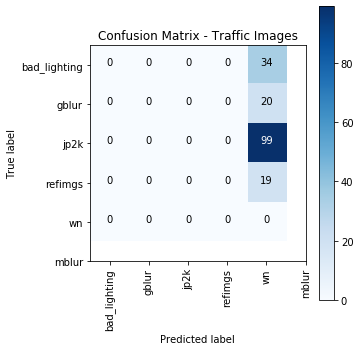

In [15]:
a=np.array(X_traffic).astype(float)
b=np.array(Y_traffic)
Y_pred = model.predict(a)



Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes), title='Confusion Matrix - Traffic Images')

In [16]:
image_classes2

['bad_lighting', 'gblur', 'refimgs', 'mblur']

In [17]:
random.seed()

for i in range(0,len(X_traffic)):
    if(Y_traffic[i][2] > 0):
        # Specify the kernel size. 
        # The greater the size, the more the motion. 

        kernel_size_h = random.randrange(30, 60, 5)


        # Apply the horizontal kernel. 
        horizonal_mb = horizontal_motion_blur(X_traffic[i],kernel_size_h)
        
#        plt.imshow(X_traffic[i], interpolation='nearest')
#        plt.show()
        
#        plt.imshow(horizonal_mb, interpolation='nearest')
#        plt.show()
        X_traffic.append(horizonal_mb)
        Y_traffic.append([0,0,0,1])

In [18]:
a=np.array(X_traffic).astype(float)
b=np.array(Y_traffic)
Y_pred = traffic_model.predict(a)



Y_pred_classes = np.argmax(Y_traffic,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes2), title='Confusion Matrix - Traffic Images - Full Set - Only For Count')

NameError: name 'traffic_model' is not defined

[1 5 5 5 0 5 0 0 5 1 0 1 3 0 5 5 0 0 1 0 5 5 1 5 0 1 5 5 5 3 1 0 0 0 1 1 1
 1 1 3 1 1 3 1 1 1 3 1 1 1 1 3 1 1 5 1 5 0 5 1 1 5 1 5 5 1 0 1 5 5 1 1 5 3
 1 1 1 5 0 1 1 5 5 1 1 1 3 5 1 5 5 5 5 5 5 5 1 0 1 1 1 3 5 5 5 1 5 5 5 5 5
 5 5 1 1 1 5 1 1 1 5 0 1 1 1 3 5 1 5 1 5 1 3 0 1 3 5 1 5 5 5 1 5 5 1 5 1 5
 1 1 1 5 5 3 3 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5
 5 5 5 5 3 5 5 3 5 3 5 5 1 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 3 5 5 5 1 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 3 5 5 5 5 5
 5 5 5 3 5 5 5 5 5 5 5 5]
[[ 12   7   2  13]
 [  0  16   4   0]
 [  6  42   6  45]
 [  0   3  11 104]]


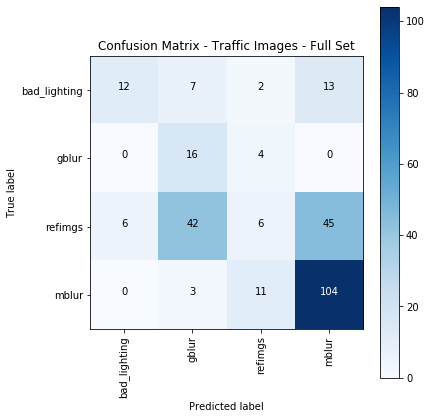

0.5092250922509225

In [89]:
y_t = []

for el in Y_traffic:
    y_t.append([el[0],el[1],0,el[2],0,el[3]])

    
a=np.array(X_traffic).astype(float)
b=np.array(y_t)

Y_pred = model.predict(a)

Y_pred_classes = np.argmax(Y_pred,axis=1)
print(Y_pred_classes)


confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
print(confusion_mtx)
plot_confusion_matrix(confusion_mtx, classes = list(image_classes2), title='Confusion Matrix - Traffic Images - Full Set',figure_size=(6,6))
sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))

In [117]:

plot_index = [[],[],[],[],[],[]]

actual = np.argmax(b,axis=1)
print(actual)
for i in range(len(actual)):
    if(actual[i]!=Y_pred_classes[i] and actual[i] == 3):
        plot_index[Y_pred_classes[i]].append(i)
        
print(plot_index)
        

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5]
[[57, 66, 78, 97, 121, 133], [55, 59, 60, 62, 65, 67, 70, 71, 74, 75, 76, 79, 80, 83, 84, 85, 88, 96, 98, 99, 100, 105, 113, 114, 115, 117, 118, 119, 122, 123, 124, 127, 129, 131, 134, 137, 141, 144, 146, 148, 149, 150], [], [], [], [54, 56, 58, 61, 63, 64, 68, 69, 72, 77, 81, 82, 87, 89, 90, 91, 92, 93, 94, 95, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 116, 120, 126, 128, 130, 136, 138, 139, 140, 142, 143, 145, 147, 151, 152]]


<Figure size 1440x2880 with 0 Axes>

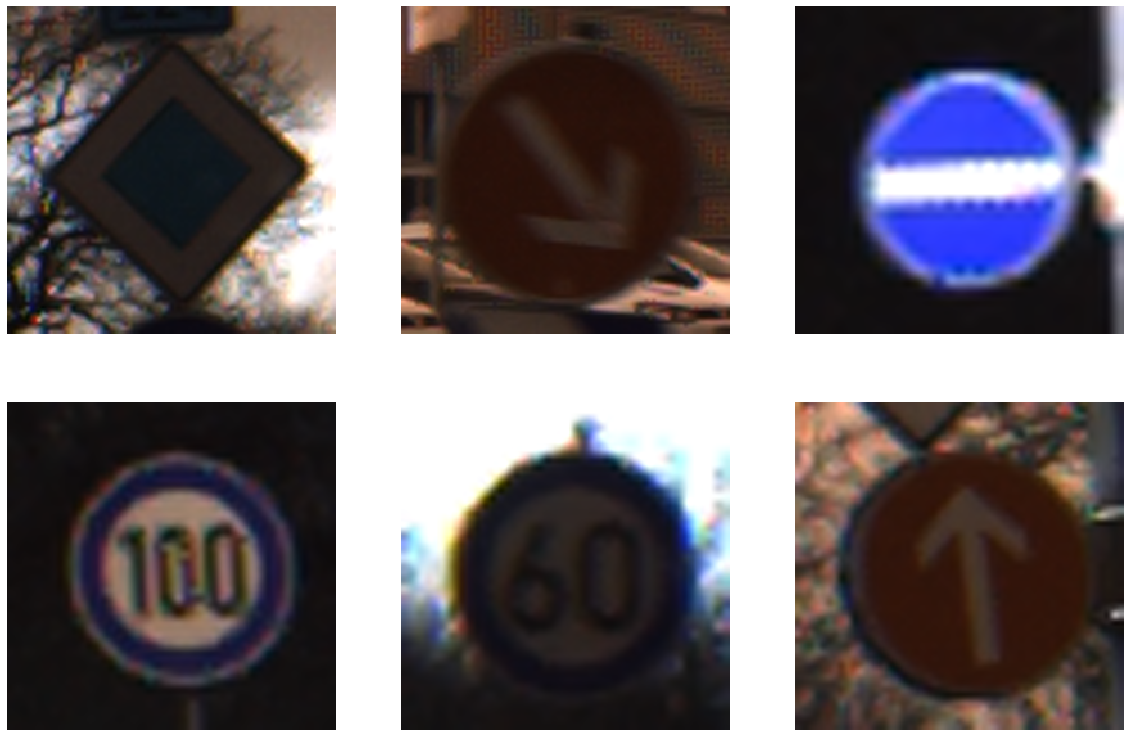

In [128]:
## Bad lighting

import math
w=10
h=10
fig=plt.figure(figsize=(20, 40))

bl_index = plot_index[0]

columns = 3
rows = math.ceil(len(bl_index)/columns)
fig=plt.figure(figsize=(20, 20*rows/columns))

for i in range(1, len(bl_index)+1):
    img = X_traffic[bl_index[i-1]]
    sp = fig.add_subplot(rows, columns, i)
    sp.axis('off')
    plt.imshow(img)
plt.show()


<Figure size 1440x2880 with 0 Axes>

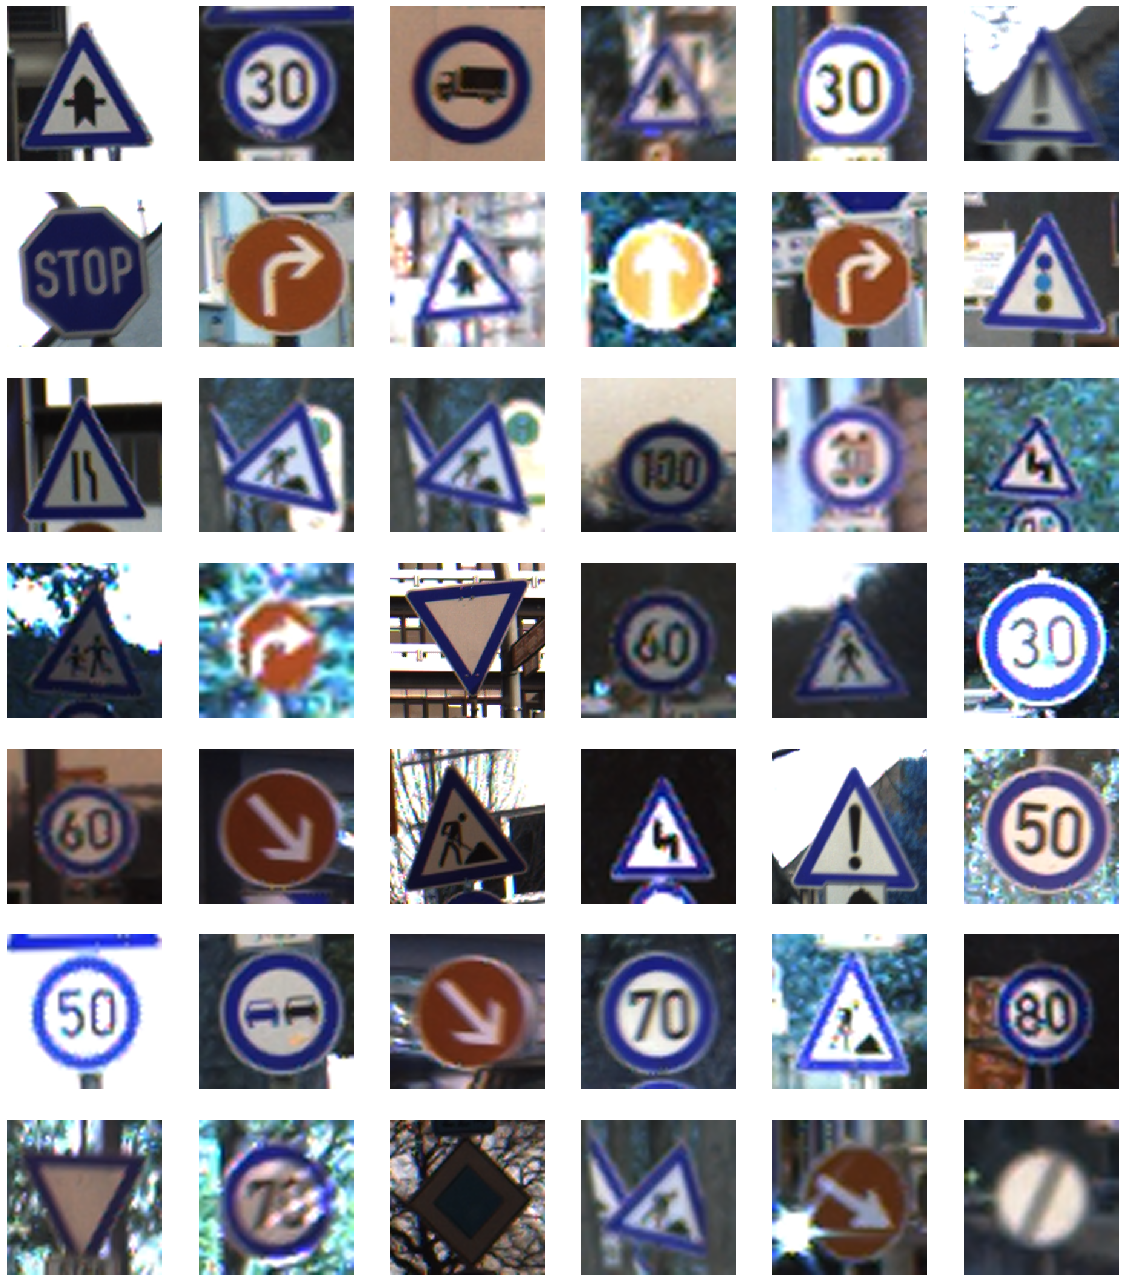

In [130]:
## gblur
import math
w=10
h=10
fig=plt.figure(figsize=(20, 40))

bl_index = plot_index[1]

columns = 6
rows = math.ceil(len(bl_index)/columns)
fig=plt.figure(figsize=(20, 20*rows/columns))

for i in range(1, len(bl_index)+1):
    img = X_traffic[bl_index[i-1]]
    sp = fig.add_subplot(rows, columns, i)
    sp.axis('off')
    plt.imshow(img)
plt.show()

<Figure size 1440x2880 with 0 Axes>

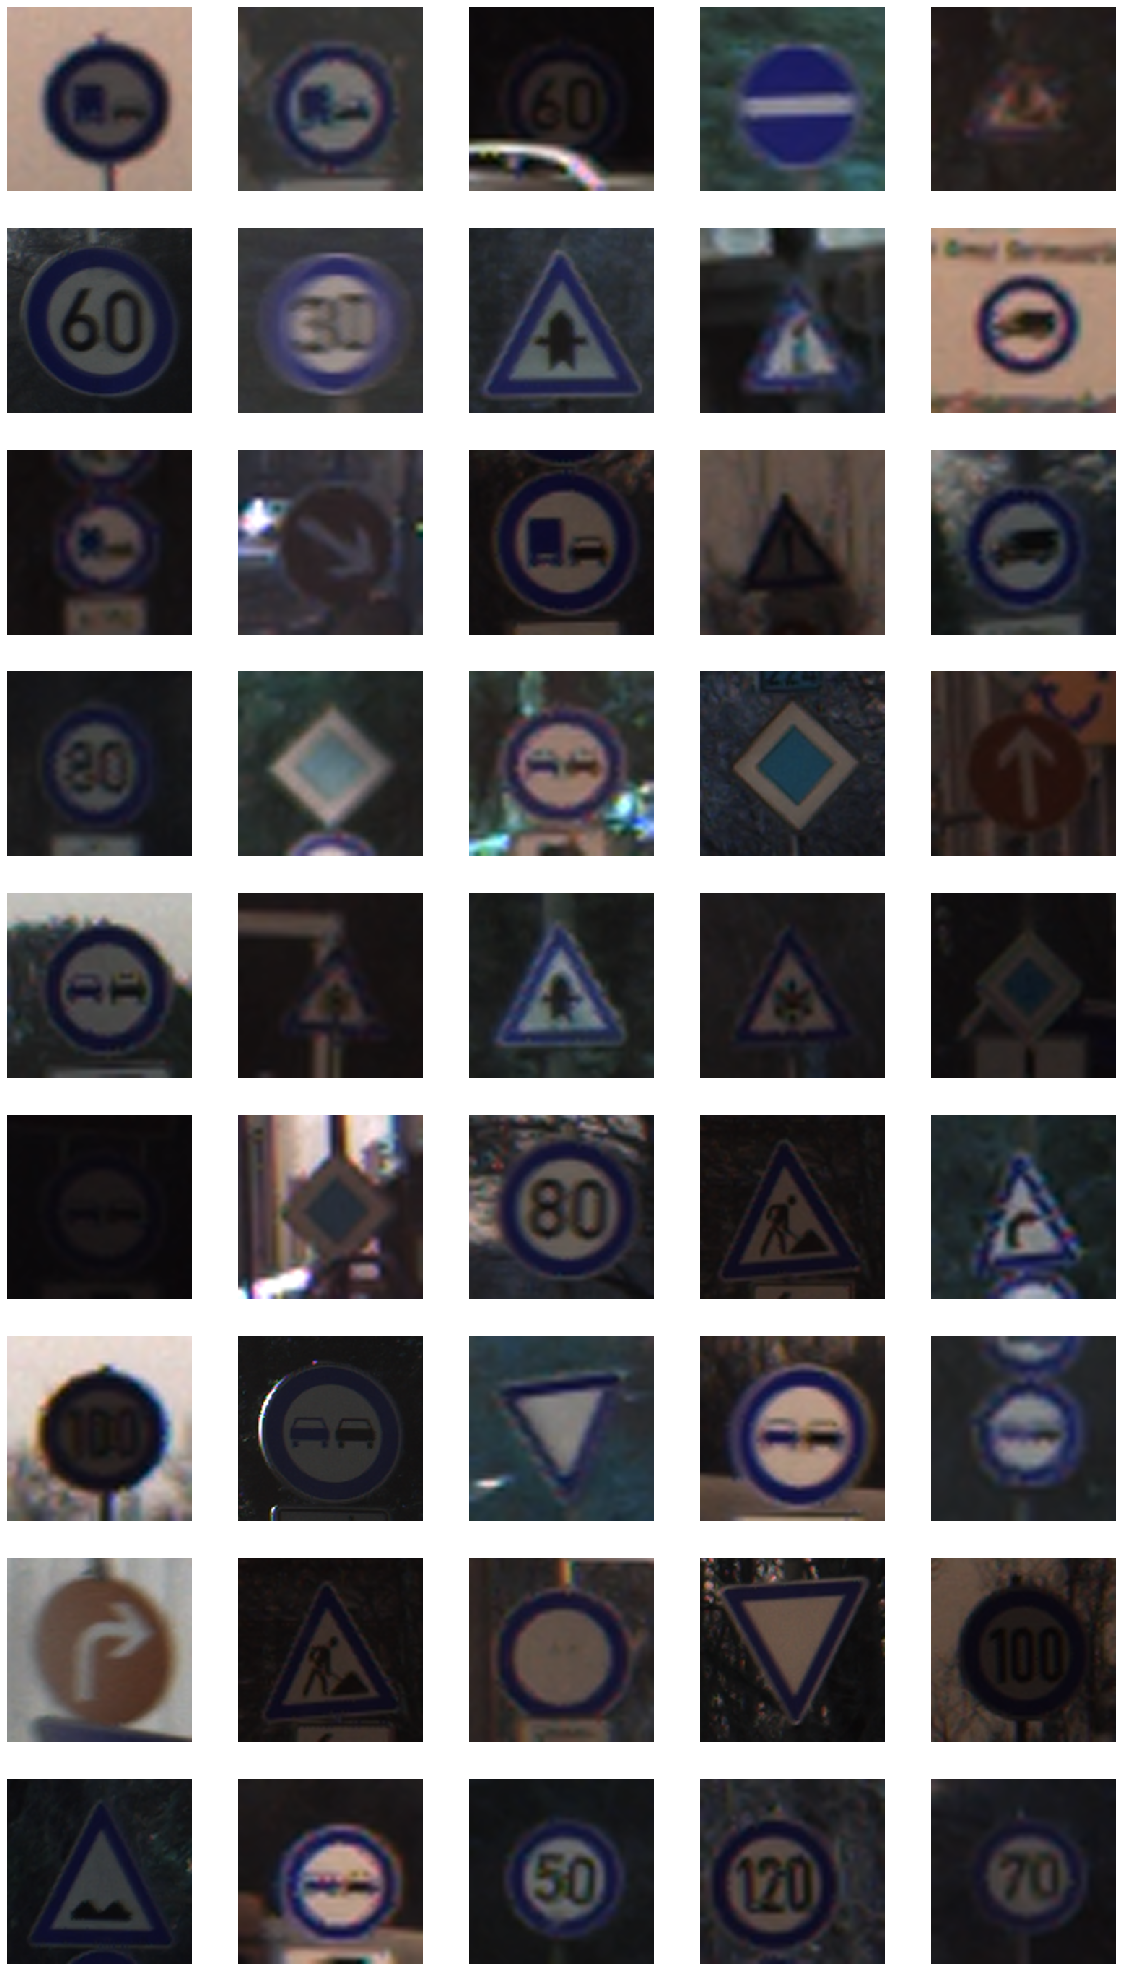

In [132]:
## mblur
import math
w=10
h=10
fig=plt.figure(figsize=(20, 40))

bl_index = plot_index[5]

columns = 5
rows = math.ceil(len(bl_index)/columns)
fig=plt.figure(figsize=(20, 20*rows/columns))

for i in range(1, len(bl_index)+1):
    img = X_traffic[bl_index[i-1]]
    sp = fig.add_subplot(rows, columns, i)
    sp.axis('off')
    plt.imshow(img)
plt.show()

In [28]:
model.load_weights('8020weights2.h5')

In [29]:
for l in model.layers:
    l.trainable = False

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 64)      0

In [19]:
traffic_predictions = Dense(4, activation='softmax')(model.layers[-4].output)
traffic_model = models.Model(inputs=model.inputs, outputs=traffic_predictions)

traffic_model.compile(
	loss='binary_crossentropy',
	optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
	metrics=['acc'])

traffic_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 64)      256   

In [20]:
print(np.array(Y_traffic).shape)
print(np.array(X_traffic).shape)
print(Y_traffic)

(271, 4)
(271, 256, 256, 3)
[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0

In [21]:

# First split the data in two sets, 80% for training, 20% for Val/Test)
X_traffic_train, X_traffic_valtest, y_traffic_train, y_traffic_valtest = train_test_split(X_traffic,Y_traffic, test_size=0.2, random_state=1, stratify=Y_traffic)

print(np.array(X_traffic_valtest).shape)
print(np.array(y_traffic_valtest).shape)

# Second split the 20% into validation and test sets
X_traffic_test, X_traffic_val, y_traffic_test, y_traffic_val = train_test_split(X_traffic_valtest, y_traffic_valtest, test_size=0.5, random_state=1, stratify=y_traffic_valtest)

print(np.array(X_traffic_train).shape)
print(np.array(X_traffic_val).shape)
print(np.array(X_traffic_test).shape)

(55, 256, 256, 3)
(55, 4)
(216, 256, 256, 3)
(28, 256, 256, 3)
(27, 256, 256, 3)


In [39]:

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect')
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(np.array(X_traffic_train), y_traffic_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_traffic_val), y_traffic_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_traffic_test), y_traffic_test, batch_size=batch_size)

history = traffic_model.fit(np.array(X_traffic_train), np.array(y_traffic_train), validation_data=(np.array(X_traffic_val), np.array(y_traffic_val)), epochs=50)



Train on 216 samples, validate on 28 samples
Epoch 1/50
216/216 [==============================] - 3s 15ms/sample - loss: 0.5496 - acc: 0.7593 - val_loss: 0.5939 - val_acc: 0.7768
Epoch 2/50
216/216 [==============================] - 1s 6ms/sample - loss: 0.5462 - acc: 0.7662 - val_loss: 0.5727 - val_acc: 0.7857
Epoch 3/50
216/216 [==============================] - 1s 6ms/sample - loss: 0.5129 - acc: 0.7789 - val_loss: 0.5532 - val_acc: 0.7857
Epoch 4/50
216/216 [==============================] - 1s 6ms/sample - loss: 0.4990 - acc: 0.7894 - val_loss: 0.5351 - val_acc: 0.8036
Epoch 5/50
216/216 [==============================] - 1s 6ms/sample - loss: 0.4885 - acc: 0.7755 - val_loss: 0.5171 - val_acc: 0.8125
Epoch 6/50
216/216 [==============================] - 1s 6ms/sample - loss: 0.4720 - acc: 0.7801 - val_loss: 0.5009 - val_acc: 0.8125
Epoch 7/50
216/216 [==============================] - 1s 6ms/sample - loss: 0.4550 - acc: 0.8090 - val_loss: 0.4857 - val_acc: 0.8036
Epoch 8/50
216/2

In [40]:

traffic_model.save_weights('8020weightsTraffic.h5')

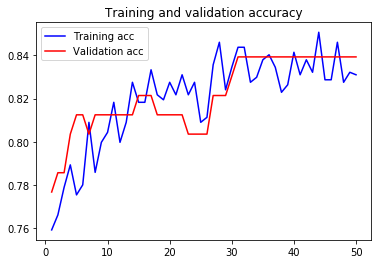

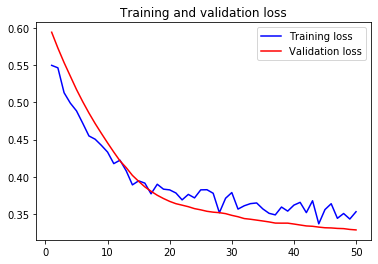

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("./fig/trvlAcc.png")
plt.show()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("./fig/trvlLoss.png")
plt.show()

In [22]:
traffic_model.load_weights('8020weightsTraffic.h5')

In [23]:
train_traffic_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.90, 1.1],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect')
valtest_traffic_datagen = ImageDataGenerator(rescale=1. / 255)

train_traffic_generator = train_traffic_datagen.flow(np.array(X_traffic_train), y_traffic_train, batch_size=batch_size)
validation_generator = valtest_traffic_datagen.flow(np.array(X_traffic_val), y_traffic_val, batch_size=batch_size)
test_traffic_generator = valtest_traffic_datagen.flow(np.array(X_traffic_test), y_traffic_test, batch_size=batch_size)
cb = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=20,verbose=0,mode='auto',baseline=None,restore_best_weights=True)

history_traffic = traffic_model.fit(np.array(X_traffic_train), np.array(y_traffic_train), validation_data=(np.array(X_traffic_val), np.array(y_traffic_val)), epochs=2000, callbacks=[cb])


Train on 216 samples, validate on 28 samples
Epoch 1/2000
 32/216 [===>..........................] - ETA: 23sWARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


KeyboardInterrupt: 

In [44]:
traffic_model.save_weights('8020weights2Traffic.h5')

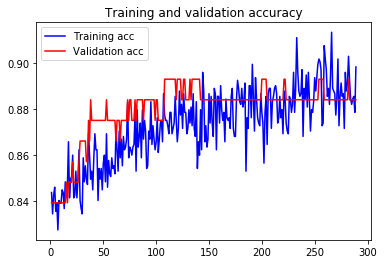

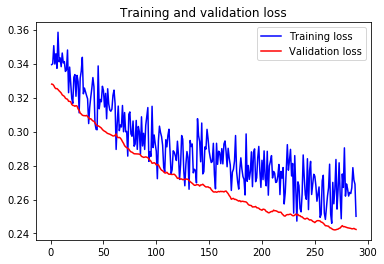

In [45]:
acc = history_traffic.history['acc']
val_acc = history_traffic.history['val_acc']
loss = history_traffic.history['loss']
val_loss = history_traffic.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("./fig/trvlAccTraffic.png")
plt.show()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("./fig/trvlTraffic.png")
plt.show()

In [24]:
traffic_model.load_weights('8020weights2Traffic.h5')

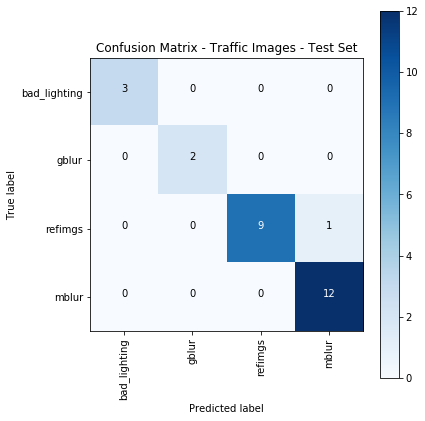

0.9629629629629629

In [29]:
a=np.array(X_traffic_test).astype(float)
b=np.array(y_traffic_test)
Y_pred = traffic_model.predict(a)



Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes2), title='Confusion Matrix - Traffic Images - Test Set',figure_size=(6,6))
sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))

In [33]:
class_totals = [sum(i) for i in confusion_mtx]
class_totals

tp = [confusion_mtx[i][i] for i in range(4)]
tp

sensetivity = [tp[i]/class_totals[i] for i in range(4)]
sensetivity

[1.0, 1.0, 0.9, 1.0]

In [34]:
fp = [[sum(x) for x in zip(*confusion_mtx)][i] - tp[i] for i in range(4)]
fp

[0, 0, 0, 1]

In [35]:
sumall = sum(map(sum, confusion_mtx))
print(sumall)
tn = [sumall - [sum(x) for x in zip(*confusion_mtx)][i] for i in range(4)]
tn
specificity = [tn[i]/(tn[i]+fp[i]) for i in range(4)]
specificity

27


[1.0, 1.0, 1.0, 0.9333333333333333]

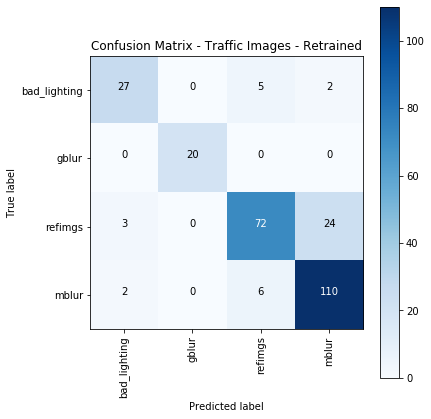

0.8450184501845018

In [39]:
a=np.array(X_traffic).astype(float)
b=np.array(Y_traffic)
Y_pred = traffic_model.predict(a)



Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes2), title='Confusion Matrix - Traffic Images - Retrained',figure_size=(6,6))
sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))

In [40]:
class_totals = [sum(i) for i in confusion_mtx]
class_totals

tp = [confusion_mtx[i][i] for i in range(4)]
tp

sensetivity = [tp[i]/class_totals[i] for i in range(4)]
sensetivity

[0.7941176470588235, 1.0, 0.7272727272727273, 0.9322033898305084]

In [41]:
fp = [[sum(x) for x in zip(*confusion_mtx)][i] - tp[i] for i in range(4)]
fp

[5, 0, 11, 26]

In [42]:
sumall = sum(map(sum, confusion_mtx))
print(sumall)
tn = [sumall - [sum(x) for x in zip(*confusion_mtx)][i] for i in range(4)]
tn
specificity = [tn[i]/(tn[i]+fp[i]) for i in range(4)]
specificity

271


[0.9795081967213115, 1.0, 0.9447236180904522, 0.8385093167701864]

In [27]:
print(Y_pred_classes)

[0 0 0 0 0 0 0 0 0 2 0 0 3 0 0 0 0 0 2 0 0 2 2 2 0 0 0 0 0 3 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 3 2 3 2 2 3 2 3 2 2 0 2 3 3 2 2 2 2
 2 2 2 3 2 2 2 2 3 2 2 2 2 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 0 3 2
 2 3 2 2 2 2 2 2 2 3 2 2 2 2 2 3 2 3 2 3 2 2 2 2 2 3 2 0 3 2 2 2 3 2 3 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 2
 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3
 3 2 3 3 3 2 3 3 3 3 3 3]


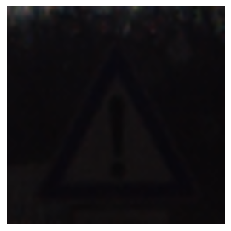

In [28]:
plt.imshow(X_traffic[6], interpolation='nearest')
plt.axis('off')
plt.show()

In [54]:

res_list = [i for i in range(len(list(Y_pred_classes))) if Y_pred_classes[i] == 3] 
print(res_list)

[3, 5, 6, 7, 8, 10, 12, 13, 15, 16, 18, 19, 25]


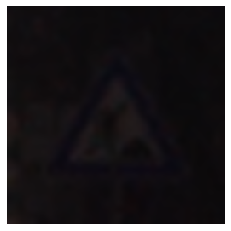

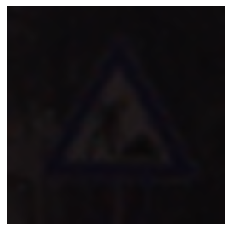

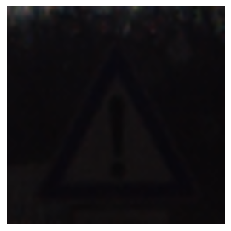

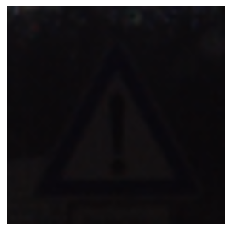

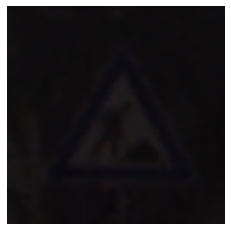

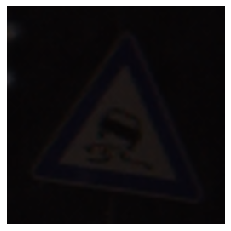

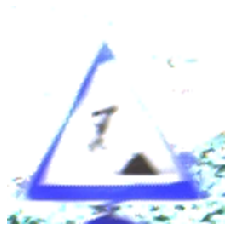

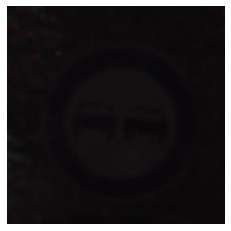

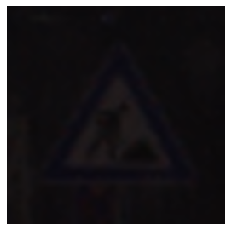

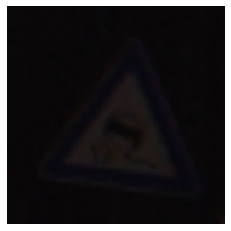

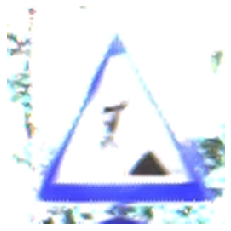

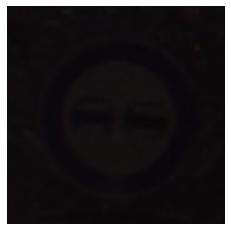

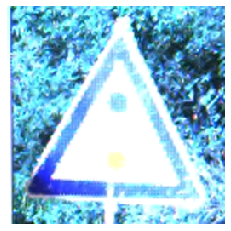

In [55]:
for i in range(0,len(res_list)):
    plt.imshow(X_traffic[res_list[i]], interpolation='nearest')
    plt.axis('off')
    plt.show()